## Title for now ##

### Introduction

A research group has set up a MineCraft server to collect data on how people play video games. Players' actions are recorded as they navigate through the world. The data includes players data as well as sessions data. In this report we aim to analyze the question: Can age and played hours predict whether a player is subscribed or not in players data?   

In the players data, there are 196 observations and 7 variables. The 7 variables are:

- experience (how experienced the player is, type chr)
- subscribe (if they are subscribed,type lgl)
- hashedEmail (player's emails, type chr)
- played_hours (number of hours the player played, type dbl)
- name (player's name, type chr)
- gender (gender of the player, type chr)
- age (age of the player, type dbl)

### Methods 

#### Preprocessing and exploratory data analysis
1. Imported relevant libraries
2. wrangled and cleaned `players.csv` data by changing `experience` and `gender` into factors
3. calculated the mean of `Age` and `played_hours`
4. created simple visualizations from the cleaned data using `Age` and `played_hour` variables in relation to `subscribe`

In [3]:
library(tidyverse)
library(tidymodels)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<fct>,<fct>,<chr>,<dbl>,<chr>,<fct>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<fct>,<fct>,<chr>,<dbl>,<chr>,<fct>,<dbl>
Amateur,FALSE,514ebbaa30f0d162127e065ab780892b7930cf8d75944d5eb09c91c02d6026c7,0.0,Orion,Male,17
Amateur,TRUE,644fe4200c19a73768b3fa598afcbd0948f7557925b7f17166285da23af31cc6,0.0,Rhys,Male,20
Amateur,TRUE,b6e9e593b9ec51c5e335457341c324c34a2239531e1890b93ca52ac1dc76b08f,0.0,Bailey,Female,17
Veteran,FALSE,71453e425f07d10da4fa2b349c83e73ccdf0fb3312f778b35c5802c3292c87bd,0.3,Pascal,Male,22
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,17
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17


mean_played_hours,mean_age
<dbl>,<dbl>
5.904639,20.52062


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


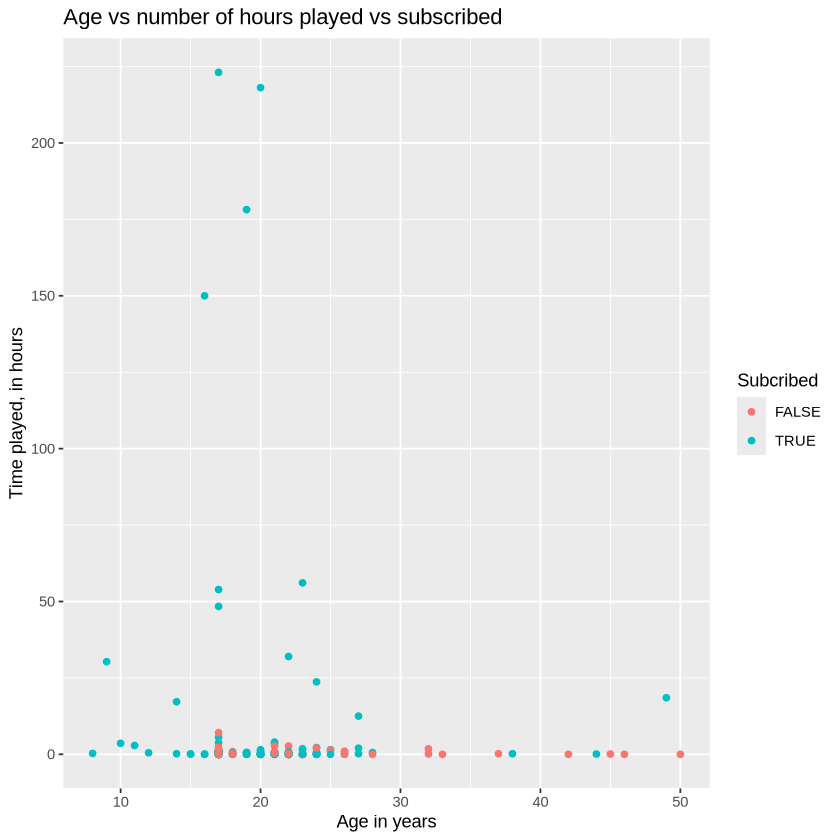

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


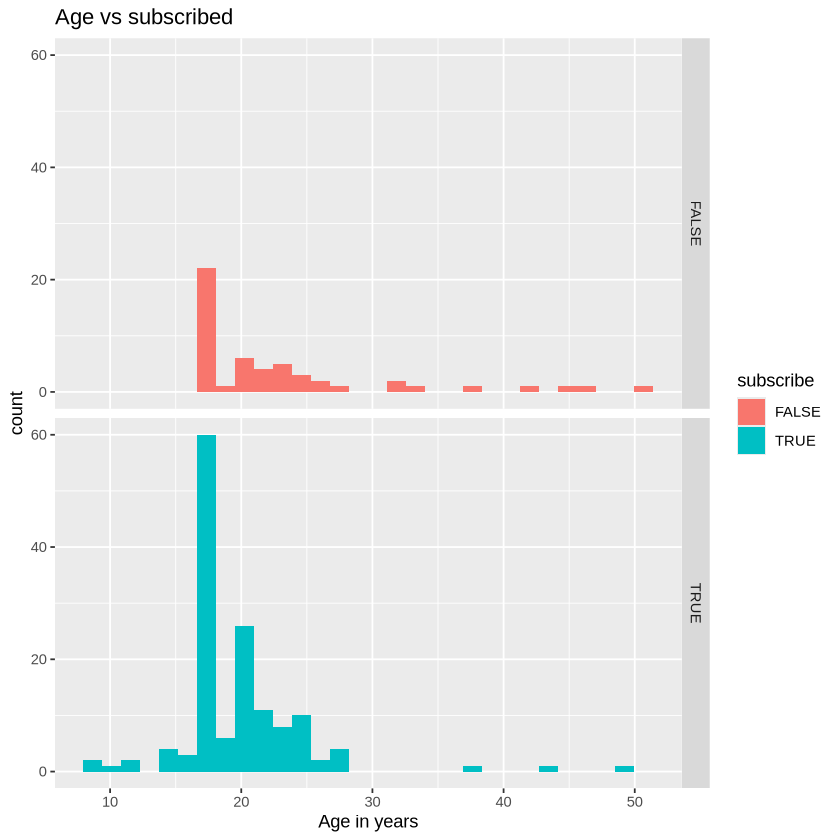

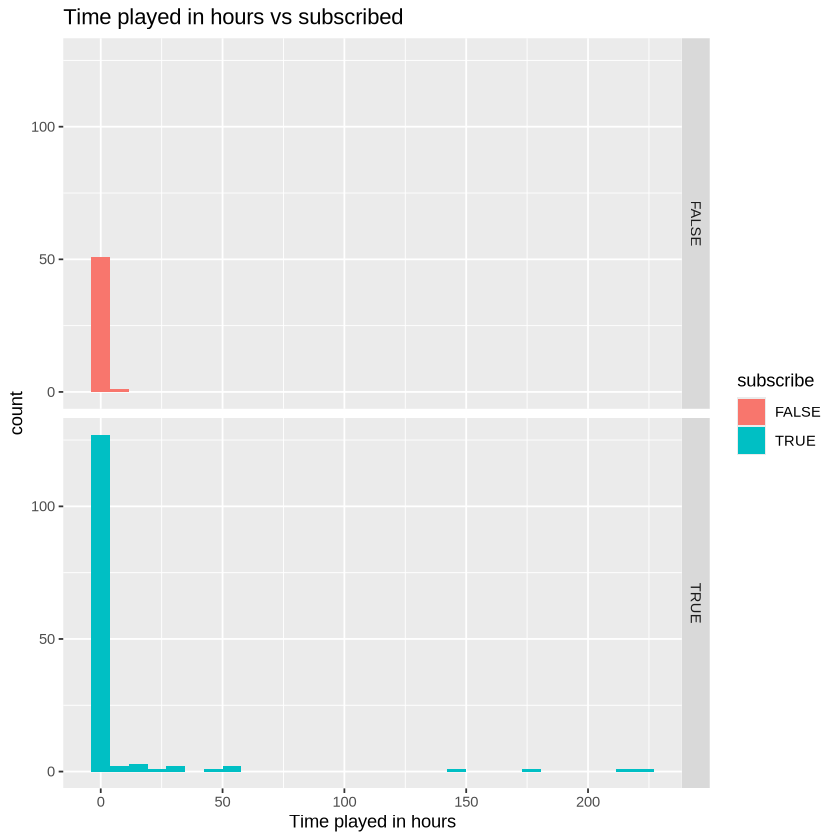

In [4]:
# set the seed
set.seed(1)

players_url<-"https://raw.githubusercontent.com/wenqin07/toy_ds_project/7ab5fe995d0e438443ebe9e80bd91a2363680d8f/players.csv"
players_data<-read_csv(players_url)

players_data_tidy<-players_data|>
    mutate(experience = as.factor(experience))|>
    mutate(gender = as.factor(gender)) |>
    mutate(subscribe = as.factor(subscribe))|>
    na.omit()


head(players_data_tidy)
tail(players_data_tidy)

players_mean<-players_data_tidy|>
    select(played_hours,Age)|>
    summarize(
          mean_played_hours = mean(played_hours, na.rm = TRUE),
          mean_age = mean(Age, na.rm = TRUE))
players_mean

explore1<-players_data_tidy|>
    ggplot(aes(x=Age,y=played_hours,color=subscribe))+
    geom_point() +
    labs(x = "Age in years",
       y = "Time played, in hours",
       color = "Subcribed",
        title= "Age vs number of hours played vs subscribed") 
explore2<-players_data_tidy|>
    ggplot(aes(x=Age,fill=subscribe))+
    geom_histogram(position = "identity") +
  facet_grid(rows = vars(subscribe)) +
    labs(x = "Age in years",
        title= "Age vs subscribed") 
explore3<-players_data_tidy|>
    ggplot(aes(x=played_hours,fill=subscribe))+
    geom_histogram(position = "identity") +
    facet_grid(rows = vars(subscribe)) +
    labs(x = "Time played in hours",
        title= "Time played in hours vs subscribed") 

explore1
explore2
explore3

data summary: 

In [6]:
#setting the seed
set.seed(1)
# Creating training and testing data 
players_split <- initial_split(players_data_tidy, prop = 0.75, strata = subscribe)
players_train <- training(players_split)
players_test <- testing(players_split)

# glimpse(players_train)
# glimpse(players_test)

# Creating players recipe
players_recipe <- recipe(subscribe ~ Age + played_hours, data = players_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

# Creating spec 
players_spec <- nearest_neighbor(weight_func = "rectangular",
                             neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

k_vals <- tibble(neighbors = seq(from = 1, to = 100, by = 1))

# Creating 5 fold cross validation
players_vfold <- vfold_cv(players_train, v = 5, strata = subscribe)

# fit the knn model
players_fit <- workflow() |>
  add_recipe(players_recipe) |>
  add_model(players_spec) |>
  tune_grid(resamples = players_vfold, grid = k_vals)|>
  collect_metrics()

# Lists all accuracies of K values from 1 to 100 
accuracies <- players_fit |>
  filter(.metric == "accuracy")

# pulls best K value(K = 19)
best_k <- accuracies |>
        arrange(desc(mean)) |>
        head(1) |>
        pull(neighbors)
best_k


[1] 19

In [13]:
set.seed(1)

#evaluating with best K
players_recipe <- recipe(subscribe ~ Age + played_hours, data = players_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

players_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k) |>
  set_engine("kknn") |>
  set_mode("classification")

players_fit <- workflow() |>
  add_recipe(players_recipe) |>
  add_model(players_spec) |>
  fit(data = players_train)

players_fit

#players predictions using testing set
players_test_predictions <- predict(players_fit, players_test) |>
  bind_cols(players_test)

# accuracy testing 
players_test_predictions |>
  metrics(truth = subscribe, estimate = .pred_class) |>
  filter(.metric == "accuracy")

# precision testing 
players_test_predictions |>
    precision(truth = subscribe, estimate = .pred_class, event_level="first")

# recall testing 
players_test_predictions |>
    recall(truth = subscribe, estimate = .pred_class, event_level="first")

# confusion matrix
players_confusion <- players_test_predictions |>
             conf_mat(truth = subscribe, estimate = .pred_class)
players_confusion

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(19,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.2551724
Best kernel: rectangular
Best k: 19

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7346939


Warning message:
“While computing binary `precision()`, no predicted events were detected (i.e.
`true_positive + false_positive = 0`).
Precision is undefined in this case, and `NA` will be returned.
Note that 13 true event(s) actually occurred for the problematic event level,
FALSE”


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
precision,binary,NA


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
recall,binary,0


          Truth
Prediction FALSE TRUE
     FALSE     0    0
     TRUE     13   36